In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import colors as clrs
import matplotlib as mpl
%matplotlib inline

In [2]:
path_2 = '/data/user/zrechav/compiled_hdf5s/airshowered_corsika/Corsika_20904_sample.hdf5'
file_2 = h5py.File(path_2,'r')

In [195]:
##keys of value
#'shower_neutrino_depth'
#'shower_neutrino_energy'
#'shower_neutrino_type'
#'shower_neutrino_zenith'
#'GaisserH4a_weight'
#'Muon_UnCorr_Energy_L1'

##files from picklemaker -- masking for an angle and depth and flavour
#'/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/SingleMuonMask.npy'
#'/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/Depth_mask_1.4.npy'
#'/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/Angle_mask_0.4.npy'
#'/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/Flavour_mask_NuMu.npy'

In [204]:
SingleMuonMask = np.load('/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/SingleMuonMask.npy',
                        mmap_mode='r',allow_pickle=True)
DoubleMuonMask = np.load('/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/DoubleMuonMask.npy',
                        mmap_mode='r',allow_pickle=True)
Depth_Mask = np.load('/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/Depth_mask_1.4.npy',
                    mmap_mode='r',allow_pickle=True)
Angle_Mask = np.load('/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/Angle_mask_0.4.npy',
                     mmap_mode='r',allow_pickle=True)
Flavour_Mask = np.load('/home/zrechav/scripts/air_shower_reader/picklemaking/masked_pickles/Flavour_mask_NuMu.npy',
                       mmap_mode='r',allow_pickle=True)

In [205]:
shower_neutrino_energy =file_2['shower_neutrino_energy']['value']
shower_neutrino_zenith =file_2['shower_neutrino_zenith']['value']
shower_neutrino_type =file_2['shower_neutrino_type']['value']
shower_neutrino_depth =file_2['shower_neutrino_depth']['value']
Muon_Uncorr_L1_energy = file_2['Muon_UnCorr_Energy_L1']['value']
Muon_Uncorr_L2_energy = file_2['Muon_UnCorr_Energy_L2']['value']
weight = file_2['GaisserH4a_weight']['item']
eventheader = file_2['I3EventHeader']

In [206]:
E_nu_bins=np.logspace(1,8,10+1)
nu_bin_centers = np.sqrt(E_nu_bins[:-1] * E_nu_bins[1:])
E_mu_bins=np.logspace(-1,8,10+1)
mu_bin_centers = np.sqrt(E_mu_bins[:-1] * E_mu_bins[1:])

In [207]:
MuonEnergyThreshMask=[energy>10. for energy in Muon_Uncorr_L1_energy]
Energy_Shower_Neutrino=np.float32(shower_neutrino_energy[MuonEnergyThreshMask])
Flavour_Shower_Neutrino=np.float32(shower_neutrino_type[MuonEnergyThreshMask])
Muon_UNCorr_Energy_L1 = Muon_Uncorr_L1_energy[MuonEnergyThreshMask]
Muon_UNCorr_Energy_L2 = Muon_Uncorr_L2_energy[MuonEnergyThreshMask]
GaisserH4a_weight = weight[MuonEnergyThreshMask]

In [208]:
Multiplicity_Flavor_Mask=[np.logical_and(SingleMuonMask,Flavour_Mask)]
print('len mult mask', len(Multiplicity_Flavor_Mask))
print('MultiplicityLen',np.sum(Multiplicity_Flavor_Mask))
print('angle mask len', np.sum(Angle_Mask))
print('depth mask len', np.sum(Depth_Mask))

len mult mask 1
MultiplicityLen 537
angle mask len 925
depth mask len 2220


In [209]:
##ADmask is combined mask of multiplicity, flavour, angle, and depth
for multmask in Multiplicity_Flavor_Mask:
    ADmask=np.logical_and.reduce((Angle_Mask,Depth_Mask,multmask))
    print('AD mask sum',np.sum(ADmask))
    print('E1 AD',Muon_UNCorr_Energy_L1[ADmask])
    if np.sum(ADmask)>0:
        print('I AM IN HERE')

AD mask sum 46
E1 AD [ 218.29759187  318.0026064    10.52756352  158.02276806  403.28213878
  120.63948732  778.28095915  175.05027465   18.9079255    60.20140716
  610.4767038  2121.54667059   14.03696827 1533.38603219  211.43257833
  220.50759056  185.68471667  536.44772736   13.5569775   543.74877343
  176.62667342  517.055455    469.10386022  277.71645717   27.14620282
  561.16266695   53.24302166  917.29263712 4833.70797255  296.92125235
   13.13864848   98.36056157  450.85602081  468.01707272   14.37397507
  274.68557489  184.5326544   905.73233122   21.72194513   19.15396425
  142.6600463   419.73734344  479.71663394   14.84581335   14.2254409
  239.69686143]
I AM IN HERE


In [211]:
Hist2D,xedges,yedges = np.histogram2d(Energy_Shower_Neutrino[ADmask], 
                                            Muon_UNCorr_Energy_L1[ADmask], 
                                            bins = [E_nu_bins,E_mu_bins], 
                                            weights = GaisserH4a_weight[ADmask])
print(np.max(Energy_Shower_Neutrino[ADmask]))
print(np.min(Energy_Shower_Neutrino[ADmask]))
print(np.max(Muon_UNCorr_Energy_L1[ADmask]))
print(np.min(Muon_UNCorr_Energy_L1[ADmask]))
# Calculate the total number of counts in the histogram
total_counts = np.sum(Hist2D)

# Normalize the histogram by dividing each bin's value by the total counts
normalized_hist2d = Hist2D / total_counts
print(normalized_hist2d)
print(np.argmax(Energy_Shower_Neutrino[ADmask]))
#print(Energy_Shower_Neutrino[ADmask][62])
#print(Muon_UNCorr_Energy_L1[ADmask][62])
#Each bin's value represents the probability of an event falling into that bin.

2234.3303
1.7075961
4833.707972545858
10.52756351847467
[[0.         0.         0.01247874 0.35058855 0.18839745 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.10435406 0.03336545 0.11876445 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00156697 0.03079519 0.13066226 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00495513 0.02407175 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.  

(0.1, 100000000)

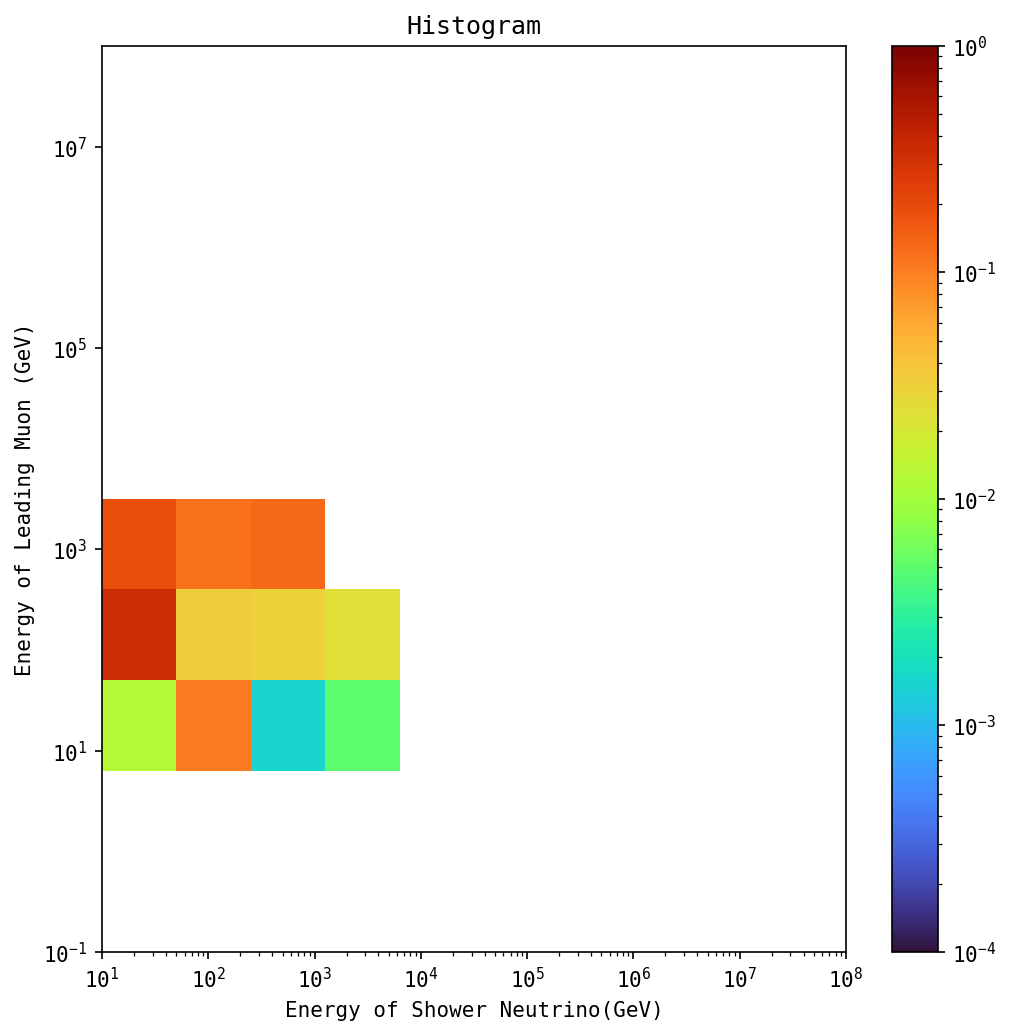

In [212]:
f, ax = plt.subplots(1,1,figsize=(8,8), dpi = 150)
mpl.rcParams["font.family"] = 'monospace'
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
vmin = 10**(-4)
vmax = 1
im=ax.pcolormesh(E_nu_bins, E_mu_bins,normalized_hist2d.T,
                 cmap='turbo',norm=clrs.LogNorm(vmin=vmin, vmax=vmax))
f.colorbar(im)
ax.set_title('Histogram')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy of Shower Neutrino(GeV)')
ax.set_ylabel('Energy of Leading Muon (GeV)')


ax.set_xlim(10**1,10**8)
ax.set_ylim(10**-1,10**8)

In [176]:
DoubleMuon_Flavour_Mask=[np.logical_and(DoubleMuonMask,Flavour_Mask)]
for multmask in DoubleMuon_Flavour_Mask:
    
    ADmask=np.logical_and.reduce((Angle_Mask,Depth_Mask,multmask))
    print('AD mask sum',np.sum(ADmask))
    print('E1 AD',Muon_UNCorr_Energy_L1[ADmask])
    print('E2 AD',Muon_UNCorr_Energy_L2[ADmask])
    if np.sum(ADmask)>0:
        print('I aint empty')

AD mask sum 104
E1 AD [1998.58569071 1031.78174297  650.73756142  265.35924286  547.59548447
  303.38487434   59.95102253  102.98855628  505.04996111   15.48541281
  308.30043572  489.21946027  161.76813398  630.0672522   399.21927697
 1170.87535389  406.23719898  628.98670943  264.03037139  343.8838543
  622.34499898  548.36924626 5002.65828426  342.62376789  520.17289808
  364.618301   2526.68799966  206.51020339  239.25890852  553.06208903
  446.01632288 4426.21482306  945.53790998  328.98244844  511.68743051
 1416.10597259 1416.10597259  373.73264152  724.17726576  788.99270684
   90.73338784  359.25134742  250.14855943  306.51500774  957.09587161
  223.91137268   34.69051195  644.49560978  390.47386782   91.75684645
 1842.68943821  268.71560963  686.89151342  218.62854002 1231.27597595
  144.60381935  569.25319129  261.85761209  338.85390543 1058.94183625
  299.65272659  436.86747905   19.20878981  517.3147967   566.55991653
  250.09317953  176.60492439  418.84197628   10.50916881

In [180]:
stackarray=np.stack((Muon_UNCorr_Energy_L1[ADmask],
                     Muon_UNCorr_Energy_L2[ADmask],
                     Energy_Shower_Neutrino[ADmask]),axis=1)
#print(stackarray)
Hist3D,edges=np.histogramdd(stackarray,
                            bins=(E_mu_bins,E_mu_bins,E_nu_bins),
                            weights=GaisserH4a_weight[ADmask])
#print(Hist3D)
for test_index in range(len(E_nu_bins)-1):
    test_nu_energy=E_nu_bins[test_index]
    Hist2D=Hist3D[:,:,test_index]
    print(np.log10(test_nu_energy))
    print('test_index: ',test_index)
    print(Hist2D)

1.0
test_index:  0
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00019711 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.0004787  0.00189602 0.00826407 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00091756 0.00527441 0.00199878 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.   

In [169]:
# Calculate the total number of counts in the histogram
total_counts = np.sum(Hist3D)

# Normalize the histogram by dividing each bin's value by the total counts
normalized_hist3d = Hist3D / total_counts

(0.1, 100000000)

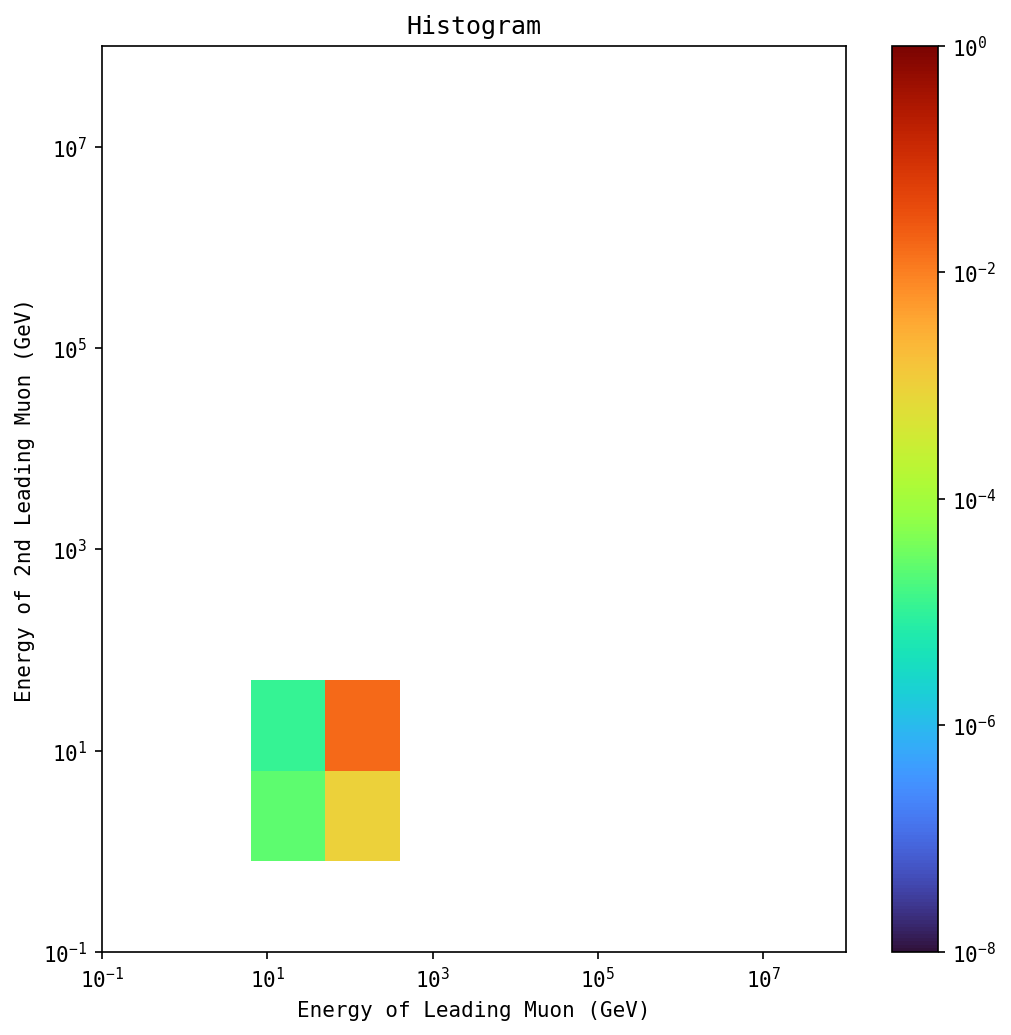

In [170]:
f, ax = plt.subplots(1,1,figsize=(8,8), dpi = 150)
mpl.rcParams["font.family"] = 'monospace'
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
vmin = 10**(-8)
vmax = 1
im=ax.pcolormesh(E_mu_bins, E_mu_bins,normalized_hist3d[:,:,2].T,
                 cmap='turbo',norm=clrs.LogNorm(vmin=vmin, vmax=vmax))
f.colorbar(im)
ax.set_title('Histogram')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy of Leading Muon (GeV)')
ax.set_ylabel('Energy of 2nd Leading Muon (GeV)')


ax.set_xlim(10**-1,10**8)
ax.set_ylim(10**-1,10**8)

In [186]:
eventheader[:5]

array([(52100001,   4, 0, 0, 1, 130612472805711614, 59000.17184353, 130612472805842978, 59000.17184353),
       (52100001,  13, 0, 0, 1, 130612472805765254, 59000.17184353, 130612472805888924, 59000.17184353),
       (52100001,  54, 0, 0, 1, 130612472805720520, 59000.17184353, 130612472805906955, 59000.17184353),
       (52100001,  91, 0, 0, 1, 130612472805805071, 59000.17184353, 130612472805937220, 59000.17184353),
       (52100001, 100, 0, 0, 1, 130612472805719610, 59000.17184353, 130612472805824463, 59000.17184353)],
      dtype={'names':['Run','Event','SubEvent','SubEventStream','exists','time_start_utc_daq','time_start_mjd','time_end_utc_daq','time_end_mjd'], 'formats':['<u4','<u4','<u4','<i4','u1','<i8','<f8','<i8','<f8'], 'offsets':[0,4,8,12,16,24,32,40,48], 'itemsize':64})